# Breaking Vigen&egrave;re

__Burton Rosenberg__
__May 2017__

## Introduction

A _cipher_ is a parameterized mapping between _plaintext_ and _ciphertext_, where the parameter is called the _secret key_. It usually is the pair: an encoding function $E_k(p)$ and a decoding function $D_k(c)$, where $k$ is the key, $p$ is the plaintext and $c$ is the ciphertext. The mappings have the property,
* $\forall p,k, D_k(E_k(p))=p$;
* and from a collection of ciphertext/plaintext pairs, $(p_i, c_i)$ where $\forall i, c_i=E_k(p_i)$, "nothing" should be learned about the key $k$.

Ciphers tend to be mathematical functions. To work over text, which are strings in a alphabet $\Sigma$, first the letters of $\Sigma$ are mapped to elements in the integers mod $n$, $Z/nZ$, where $n$ is the size of the alphabet $\Sigma$. By a mild abuse of notation, we will not explicitly show the mapping, and use plaintext elements characters as either letters in $\Sigma$ or numbers in $Z/nZ$.

A Shift Cipher is defined by the equation $E_k(\sigma)=\sigma+k \bmod{n}$. These are broken by exploiting the a priori knowledge of the relative frequency of letters in a text. I.e., that the letters e and t are the most common. A _frequency count_ of the cipher text will identify the most common letters in the ciphertext, and from there the key $k$ can be most likely determined. In fact, the entire spectrum of the letter counts can be measured, by considering the count as a vector in $Z^n$ and taking the dot-product against a sample or shift sample of a known language. The larger the dot-product, the more the two distributions coincide.

The Vigen&egrave;re Cipher is a slight complication of the Shift Cipher. The cipher was first described by Giovan Battista Bellaso in 1553 and was used in the American Civil War (1861-1865). Rather than a single character, the key is a sequence of letters, $k=k_1k_2\ldots k_r$. The letters are used in a cyclical sequence to shift the text $p=p_1p_2\ldots p_m$: 

$$
E_{k}(p_i) = p_i + k_{i \bmod r}
$$




## Incidence of Coincidence

A simple frequency count of the resulting ciphertext does not yield clearly the keyword. However, the keyword can be recovered by a sample ciphertext by first determining $r$, then breaking the ciphertext into $r$ subsequences, each for a single shift. Then each of the $r$ are broken by frequency counting.

To determine $r$, the cryptographer [Abraham Sinkov](https://en.wikipedia.org/wiki/Abraham_Sinkov) invented the [index of coincidence](https://en.wikipedia.org/wiki/Index_of_coincidence) (although it might have been his boss, [Willian Friedman](https://en.wikipedia.org/wiki/William_F._Friedman) ). The idea is that if two samples are drawn from the same non-uniform distribution, versus from two distinct non-uniform distributions, it is more likely that the two samples will be equal. Applying this to the Vigen&egrave;re, by sliding the ciphertext against itself, that is, comparing $c_i$ to $c_{i+j}$ for various $j$, when $j$ is a multiple of $r$ the coincidences as counted over various $i$ will spike.


### Coding Preliminaries

We will demonstrate the ciphers, frequency counting, and the index of coincidence with the example text, _Lincoln's Gettysburg Address_.

First we do the import and read in the file to a single long string. We will discard all characters in the input text other than the letters a through z, and we should insure they will be in lowercase. It is our convention that plaintext be in all lowercase letters, and ciphertext be in all uppercase letters.


In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab, mlab
from pylab import *

def readcharacters(filename):
    f =open(filename,"r")
    p = "" ;
    for line in f:
        for c in line :
            if c.isalpha() :
                p = p + c.lower() ;
    f.close() ;
    return p ;

pt = readcharacters("gettysburg.txt") ;
print pt ;


fourscoreandsevenyearsagoourfathersbroughtforthonthiscontinentanewnationconceivedinlibertyanddedicatedtothepropositionthatallmenarecreatedequalnowweareengagedinagreatcivilwartestingwhetherthatnationoranynationsoconceivedandsodedicatedcanlongendurewearemetonagreatbattlefieldofthatwarwehavecometodedicateaportionofthatfieldasafinalrestingplaceforthosewhoheregavetheirlivesthatthatnationmightliveitisaltogetherfittingandproperthatweshoulddothisbutinalargersensewecannotdedicatewecannotconsecratewecannothallowthisgroundthebravemenlivinganddeadwhostruggledherehaveconsecrateditfaraboveourpoorpowertoaddordetracttheworldwilllittlenotenorlongrememberwhatwesayherebutitcanneverforgetwhattheydidhereitisforusthelivingrathertobededicatedheretotheunfinishedworkwhichtheywhofoughtherehavethusfarsonoblyadvanceditisratherforustobeherededicatedtothegreattaskremainingbeforeusthatfromthesehonoreddeadwetakeincreaseddevotiontothatcauseforwhichtheygavethelastfullmeasureofdevotionthatweherehighlyresolvethatthesedea

### Shift ciphers and frequency counting

Here is the code to do a simple shift cipher, and a decode of the encoded text, to demonstrate the correctness.

In [8]:
def shiftencipher(p,k):
    c = "" ;
    for pi in p:
        x = ord(pi)-ord('a');
        y = (x + k) % 26 ;
        c += chr(y+ord('A')) ;
    return c ;

def shiftdecipher(c,k):
    p = "" ;
    for ci in c:
        y = ord(ci)-ord('A');
        x = (y - k) % 26 ;
        p += chr(x+ord('a')) ;
    return p ;

ct = shiftencipher(pt,3) ;
ptx = shiftdecipher(ct,3) ;
print "The cipher text is:", ct, "\n" ;
print "Decoding the cipher text is:", ptx, "\n";


The cipher text is: IRXUVFRUHDQGVHYHQBHDUVDJRRXUIDWKHUVEURXJKWIRUWKRQWKLVFRQWLQHQWDQHZQDWLRQFRQFHLYHGLQOLEHUWBDQGGHGLFDWHGWRWKHSURSRVLWLRQWKDWDOOPHQDUHFUHDWHGHTXDOQRZZHDUHHQJDJHGLQDJUHDWFLYLOZDUWHVWLQJZKHWKHUWKDWQDWLRQRUDQBQDWLRQVRFRQFHLYHGDQGVRGHGLFDWHGFDQORQJHQGXUHZHDUHPHWRQDJUHDWEDWWOHILHOGRIWKDWZDUZHKDYHFRPHWRGHGLFDWHDSRUWLRQRIWKDWILHOGDVDILQDOUHVWLQJSODFHIRUWKRVHZKRKHUHJDYHWKHLUOLYHVWKDWWKDWQDWLRQPLJKWOLYHLWLVDOWRJHWKHUILWWLQJDQGSURSHUWKDWZHVKRXOGGRWKLVEXWLQDODUJHUVHQVHZHFDQQRWGHGLFDWHZHFDQQRWFRQVHFUDWHZHFDQQRWKDOORZWKLVJURXQGWKHEUDYHPHQOLYLQJDQGGHDGZKRVWUXJJOHGKHUHKDYHFRQVHFUDWHGLWIDUDERYHRXUSRRUSRZHUWRDGGRUGHWUDFWWKHZRUOGZLOOOLWWOHQRWHQRUORQJUHPHPEHUZKDWZHVDBKHUHEXWLWFDQQHYHUIRUJHWZKDWWKHBGLGKHUHLWLVIRUXVWKHOLYLQJUDWKHUWREHGHGLFDWHGKHUHWRWKHXQILQLVKHGZRUNZKLFKWKHBZKRIRXJKWKHUHKDYHWKXVIDUVRQREOBDGYDQFHGLWLVUDWKHUIRUXVWREHKHUHGHGLFDWHGWRWKHJUHDWWDVNUHPDLQLQJEHIRUHXVWKDWIURPWKHVHKRQRUHGGHDGZHWDNHLQFUHDVHGGHYRWLRQWRWKDWFDXVHIRUZKLFKWKHBJDYHWKHODVWIXOOPHDVXUHRIGHYRWLRQWKDWZHKHUHKLJKO

Now we look at frequency counts. We frequency count both the original and the shift enciphered text. Note that the bar plots are simple shifts of each other.

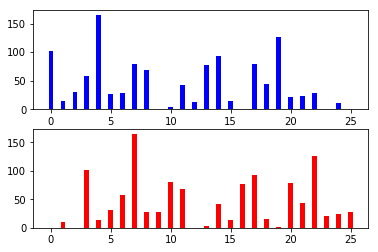

In [9]:

def frequencycount(s):
    count = [0 for i in range(26)] ;
    for c in s :
        i = ord(c.lower())-ord('a') ;
        count[i] += 1 ;
    return count ;
    
f, sp = plt.subplots(2) ;
w = 0.4 ;
fc = frequencycount(pt)
y = range(len(fc)) ;
sp[0].bar(y,fc,w, color="blue")
fc = frequencycount(ct)
sp[1].bar(y,fc,w, color="red")
plt.show()

### The vigen&egrave;re and its frequency counts

We now implement and demonstate the Vigen&egrave;re Cipher.

In [10]:
def vigenereencipher(p,k):
    c = "" ;
    i = 0 ;
    for pi in p:
        x = ord(pi)-ord('a');
        j = ord(k[i].lower()) - ord('a') ;
        y = (x + j) % 26 ;
        c += chr(y+ord('A')) ;
        i += 1
        if i>=len(k):
            i = 0 ;
    return c ;

def vigeneredecipher(c,k):
    p = "" ;
    i = 0 ;
    for ci in c:
        y = ord(ci)-ord('A');
        j = ord(k[i].lower()) - ord('a') ;
        x = (y - j) % 26 ;
        p += chr(x+ord('a')) ;
        i += 1 ;
        if i>=len(k):
            i = 0 ;
    return p ;

pt = readcharacters("gettysburg.txt") ;
ct = vigenereencipher(pt,"liberty") ;
ptx = vigeneredecipher(ct,"liberty") ;
print "The cipher text is:", ct, "\n" ;
print "Decoding the cipher text is:", ptx, "\n";


The cipher text is: QWVVJVMCMBRULCGMOCVTPDIHSFNPQIULVKQMZPYXARQWSXYHLEPJWTHLEQOIEMYYMXRRMGZVDSEVCTDFHZGJTJFVKRYYLEIUBALBFHKHRSMQVFIMDQUMFGRSIUECEKPVBVVVPPIUIUXOFIMRFPUPISIVGELOFHZGYRZFEKVGGQMARKRPAUMEZUSMULVKRSIURRMGZVPVRGWYIUMFGQZKPRTXGGMEEEWQZLFHZVYEMEGRGJZVHIEWSCMXIRKCXMUSETECMBXSTRETFJZXJOWGXYTRHISAVAYGMDSDXRZLFHZVYEMBTFKRTWOSWMFLBGMVEBLABJZGYWZFWKBLRXMETXDZZULFLCHPPLVKCRIWIKACTZMMMXQEPBXKAYEVBXZHLXQHLKEGGMJXZLYWBPKVMFPZGMKMGYOBRUIPZXFVKAYEEFWYHSWLESKAGDJVXZGYWISKVKQPVTINXALVOSKWCOQDEKXUPKBREHRNWOWVVPLBFAVVYYVPXYTJWWXXYBQRZPYEWRSMCVROCXMOPZOGYOBRUWCLLXLFLRCCHKCXBSMSIYTTPKPRJXACIUIUBRQISESHTPWVVGHMCXPAVKRZIEHFKBPBSETMRSMXSIEBHQMPCBRETFRFMCYWSPFGECMNIDUCCEIEKPCDIZLVKCMCUMKVYYVFZVKDZZHIKPFLBULVRBTLIIIXGEQTJFKSDBIICBTTVHVRMFPZUSSXBPLJGRMCOPFVVMMEPFYEYGYQTLVWUZZLAYBASBIIPPFZNPYXARSMSIYTTPBIYJYYCAPRFUJJIEZRGAPLJXZLPLBIIIYMCCTXFUCSMSIUXBTKBXVWRZBIIXKCLBUEJDPPUBMEBLRJFJFKCFAULRMDCWNXYXQPPPRFKCOLFEUPCEILIZGACMBWVWBPDPXZHLEWULRMALCTIWHPHPJGYMFPGHEMXRSMMEJMDFTMQVTQFZFSWWCGWUMFGRSIUAVACCMIMXAJ

Frequency counting the result of the Vigen&egrave;re Cipher shows that the encipherment does somewhat uniformize the ciphertext frequency count.

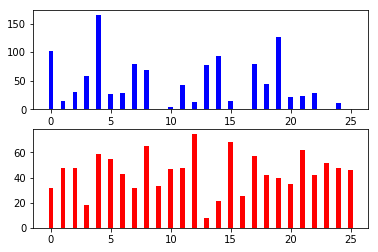

In [11]:
f, sp = plt.subplots(2) ;
y = range(len(fc)) ;
w = 0.4 ;
fc = frequencycount(pt)
sp[0].bar(y,fc,w, color="blue")
fc = frequencycount(ct)
sp[1].bar(y,fc,w, color="red")
plt.show()

### The Index of Coincidence and its consequences

However, the Index of Coincidence can find the periodicity in the encipherment. The graph shows the relative frequency of collisions between the ciphertext and itself, for different amounts of shift in the indices when doing the comparison. Count between the peaks and see if you can identify a repeating interval.

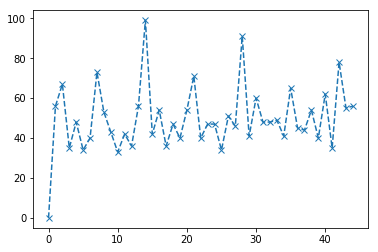

In [12]:
def encodearray(p):
    l = [] ;
    for c in p :
        l.append(ord(c.lower())-ord('a')) ;
    return np.array(l) ;

def calcioc(p,n) :
    ca = encodearray(p) ;
    ioc = [] ;
    for i in range(n):
        ioc.append(np.sum(ca==np.roll(ca,i))) ;
    ioc[0]=0;
    return ioc

pt = readcharacters("gettysburg.txt") ;
ct = vigenereencipher(pt,"liberty") ;
ioc = calcioc(ct,45) ;
plt.plot(range(len(ioc)),ioc,"x--") ;



The peaks occur at intervals of seven, so the code word must be seven letters in length. We can now take every seventh letter from the ciphertext, with offsets 0 through 6, and apply the cryptoanalysis of a shift cipher to the resulting subtext. In the following, I have gone through and shifted the frequency count of the plaintext (in blue) to match each of the frequency counts of the first subtext, at shifts 0, 1 and 2 (in red). What do these numbers say about the keyword?

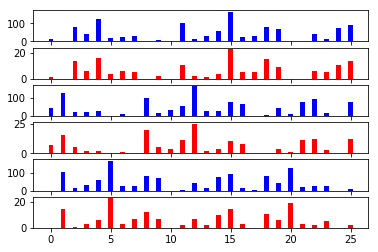

In [13]:
peaks = 7 ;
w = 0.4 ;
f, sp = plt.subplots(6) ;

# these are the shift amounts to make the f.c.'s coincide
ra = [11,8,1] ;

ptfc = frequencycount(pt) ;

for i in range(3) :
    sp[2*i].bar(range(len(ptfc)) ,roll(ptfc,ra[i]),w, color="blue") 
    fc = frequencycount(ct[i::peaks]) ;
    sp[2*i+1].bar(range(len(fc)),fc,w, color="red") ;
    


### Exercises

Using dot product, it should be possible to automatically align these distributions. As described, this uses a ciphertext, plaintext pair to recover the key. It is not necessary to have a known plaintext, as a sample of sufficiently similar distribution, e.g. any other english language text, and work also for the plaintext. 

On might also consider how to identify the peaks in the trace of the index of coincidence.

* Devise an algorithm to determine the shift in shift cipher, and implement
* Devise an algorithm to identify the key length from the index of coincidence, and implement.
* Consider a way to determine  a source text's language (i.e. is it english, spanish?), and implement.
